# Deep Learning
## Formative assessment
### Week 2: Multilayer perceptrons

#### Instructions

In this notebook, you will write code to implement and train a multilayer perceptron in TensorFlow using the high-level Keras API.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset. 

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

from keras.models import Sequential
from keras.layers import Dense

# If you would like to make further imports from Tensorflow, add them here




<img src="figures/bike_sharing.jpg" title="Bike sharing" style="width: 500px;"/>
<center><font style="font-size:12px">source: <a href=https://www.visitlondon.com/traveller-information/getting-around-london/london-cycle-hire-scheme>visitlondon.com</a></font></center>

#### The Bike Sharing dataset
In this formative assessment, you will use the [Bike Sharing dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) from the UCI Machine Learning Repository. This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

* Fanaee-T, H,, & Gama, J. (2013), "Event labeling combining ensemble detectors and background knowledge", _Progress in Artificial Intelligence_, 1-15, Springer Berlin Heidelberg.

Your goal is to use TensorFlow to model the dataset using linear regression and MLP networks.

#### Load and preprocess the data

In [2]:
# Run this cell to load and sample the data

df = pd.read_csv(Path("./data/bike_sharing.csv"))
df.sample(10)

,year,season,month,day_name,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
1962,2011,2,3,Sunday,14,0,0,0,1,0.32,0.3182,0.36,0.1642,61,103
9163,2012,1,1,Sunday,17,0,0,0,2,0.16,0.1818,0.80,0.1045,8,100
16445,2012,4,11,Thursday,23,1,4,0,1,0.30,0.3333,0.70,0.0000,8,28
9127,2012,1,1,Saturday,5,0,6,0,3,0.16,0.1818,0.86,0.1045,0,2
4922,2011,3,7,Friday,0,0,5,1,1,0.74,0.7121,0.79,0.1642,12,45
16902,2012,4,12,Wednesday,1,0,3,1,1,0.28,0.2727,0.61,0.2239,3,18
6474,2011,4,10,Sunday,8,0,0,0,2,0.34,0.3333,0.76,0.1940,14,50
11389,2012,2,4,Tuesday,18,0,2,1,1,0.50,0.4848,0.18,0.0000,52,580
6437,2011,4,9,Friday,19,0,5,1,1,0.54,0.5152,0.52,0.2836,42,332
16557,2012,4,11,Tuesday,15,0,2,1,2,0.30,0.2727,0.75,0.2985,9,146


See [the dataset description](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) for more information on the attributes. There are two target variables: `casual` (number of casual users) and `registered` (number of registered users).

You should first complete the following `get_inputs_and_targets` function, according to the following spec:

* The function takes inputs `dataframe` and `target_variables`
  * The `target_variables` is a list of column names that we will use for the targets
* The function should return a tuple of DataFrames `(inputs_df, targets_df)`, where `targets_df` contains only the columns in `target_variables`, and `inputs_df` contains all the remaining columns.

In [3]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_inputs_and_targets(dataframe, target_variables):
    """
    This function takes in the loaded DataFrame and target_variables list as above, 
    and returns inputs and targets DataFrames.
    """
    inputs_df = dataframe.drop(target_variables, axis = 1)
    targets_df = dataframe[target_variables]
    return (inputs_df, targets_df)
    

In [4]:
# Run your function to get the input and target Tensors

inputs_df, targets_df = get_inputs_and_targets(df, target_variables=['casual', 'registered'])
print(inputs_df)


       year  season  month  day_name  hr  holiday  weekday  workingday  \
0      2011       1      1  Saturday   0        0        6           0   
1      2011       1      1  Saturday   1        0        6           0   
2      2011       1      1  Saturday   2        0        6           0   
3      2011       1      1  Saturday   3        0        6           0   
4      2011       1      1  Saturday   4        0        6           0   
...     ...     ...    ...       ...  ..      ...      ...         ...   
17374  2012       1     12    Monday  19        0        1           1   
17375  2012       1     12    Monday  20        0        1           1   
17376  2012       1     12    Monday  21        0        1           1   
17377  2012       1     12    Monday  22        0        1           1   
17378  2012       1     12    Monday  23        0        1           1   

       weathersit  temp   atemp   hum  windspeed  
0               1  0.24  0.2879  0.81     0.0000  
1        

The data will need some preprocessing before it is ready to be used to train a deep learning model. 

Firstly, several of the attributes are categorical: `year`, `season`, `month`, `day_name`, `hr`, `holiday`, `weekday`, `workingday` and `weathersit`. We will represent each of these attributes with a one-hot encoding. For example, `year` takes one of the values `2011` or `2012` in the dataset. Will represent the year of a data example as either the one-hot vector `[1, 0]` or `[0, 1]`, corresponding to the year `2011` or `2012` respectively. In general, the length of the one-hot vector will equal the number of categories, and will be all zeros except for a single one in the place of the corresponding category for a particular data example.

The final representation of our inputs will be the concatenation of all features, including one-hot vectors.

You should now complete the following `convert_to_one_hot` function, according to the following specifications:

* The function takes the inputs `inputs_dataframe` and `categorical_attributes`
    * `categorical_attributes` will be a list of column names that are present in `inputs_dataframe`
* The function should convert each categorical feature to a one-hot vector by replacing the column with a number of columns equal to the number of categories
* The function should then return the updated DataFrame

_Hint: see [`pd.get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), and note that numerical columns can be converted to `category` type in order for this function to correctly the column as categorical._

In [5]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def convert_to_one_hot(inputs_dataframe, categorical_attributes):
    """
    This function takes in the loaded DataFrame and categorical_attributes list as above, 
    and converts the categorical features to one-hot encodings.
    Your function should return the DataFrame.
    """
    for col in categorical_attributes:
        inputs_df[col] = inputs_dataframe[col].astype("category")
    
    return pd.get_dummies(inputs_dataframe[categorical_attributes],dtype = int)


In [6]:
# Run your function to convert the categorical features to one-hot encodings

cols = ['year', 'season', 'month', 'day_name', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
inputs_df = convert_to_one_hot(inputs_df, cols)
print(inputs_df)


       year_2011  year_2012  season_1  season_2  season_3  season_4  month_1  \
0              1          0         1         0         0         0        1   
1              1          0         1         0         0         0        1   
2              1          0         1         0         0         0        1   
3              1          0         1         0         0         0        1   
4              1          0         1         0         0         0        1   
...          ...        ...       ...       ...       ...       ...      ...   
17374          0          1         1         0         0         0        0   
17375          0          1         1         0         0         0        0   
17376          0          1         1         0         0         0        0   
17377          0          1         1         0         0         0        0   
17378          0          1         1         0         0         0        0   

       month_2  month_3  month_4  ...  

In the second stage of preprocessing, we will scale the values in both the inputs and the targets.

You should now complete the following `scale_values` function, according to the following spec:

* The function takes the `inputs_df` and `targets_df` DataFrames as arguments
* The feature values in `inputs_df` should be linearly scaled to the range $[0, 1]$. Note that this will not affect the features that have been one-hot encoded. _Hint: use the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from `sklearn`._
* The values in the `targets_df` are counts, and these should be converted as follows:
$$\text{count} \mapsto \log (1 + \text{count})$$
where the log is the natural logarithm.
* The function should then return a tuple of Tensors `(inputs, targets)` of type `tf.float32` with the transformed values

In [7]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def scale_values(inputs_df, targets_df):
    """
    This function takes in the inputs and targets DataFrames and scales the values
    in each DataFrame according to the above description.
    Your function should return a tuple of Tensors.
    """
    #targets
    targets_df = np.log(1 + targets_df)
    #inputsinputs_df
    scaler = MinMaxScaler()
    scaler.fit(inputs_df)
    return scaler.transform(inputs_df), targets_df
    
    
    

In [8]:
# Run your function to get the scaled inputs and outputs Tensors
inputs, targets = scale_values(inputs_df, targets_df)

In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.3)

X_train, y_train = tf.constant(X_train), tf.constant(y_train)
X_val, y_val = tf.constant(X_val), tf.constant(y_val)


#### Linear regression model

We will first fit a simple linear regression model to the training data. Recall that this is a model of the form

$$
y = f_\theta(\mathbf{x}) + \epsilon,
$$

where $y\in\mathbb{R}^C$ is the target variable, $\mathbf{x}\in\mathbb{R}^{D}$ are the input features, $\Theta\in\mathbb{R}^{C\times D+1}$ are the model parameters, $\epsilon\in\mathbb{R}^C$ with $(\epsilon)_c\sim\mathcal{N}(0, 1)$ $(c=1,\ldots,C)$ is the observation noise random variable, and $f_\Theta:\mathbb{R}^{D+1}\mapsto\mathbb{R}$ is given by

$$
f_\Theta(\hat{\mathbf{x}}) = \Theta\hat{\mathbf{x}},
$$

where $\hat{\mathbf{x}}\in\mathbb{R}^{D+1}$ is constructed by adding a constant 1 feature to $\mathbf{x}$; that is, $\hat{\mathbf{x}}_0=1$.

We will use the Keras API to implement a linear regression model, using the `Sequential` class.

In the following function, you should build a `Sequential` model with just one `Dense` layer, which has two output units, one for each target variable, and no activation function. This is the same as the linear regression model above.

* The function takes the `input_shape` as an argument, which should be used in the `Dense` layer initializer to specify the input shape
* The function should build and return the `Sequential` object with one Dense layer with two output neurons, and no activation function

In [18]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def sequential_linear_regression(input_shape):
    """
    This function takes the input_shape as argument to build a Sequential model as 
    specified above. 
    The function should then return the Sequential model.
    """
    #INPUT DIMENSION IS USUALLY INFERRED WHEN FIRST LAYER IS CALLED, BUT IF WE TELL IT, THEN IT CAN INITIALISE BEFORE SEEING THE DATA, since it knows how many weights to make etc
    model = Sequential([
        Dense(2, input_shape = input_shape)
    ])
    
    return model
    

In [19]:
# Run your function to build the model and print the model summary

lr_model = sequential_linear_regression(input_shape=X_train.shape[1:])
lr_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 130 (520.00 Byte)
Trainable params: 130 (520.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You should now compile and fit the model to the training data. 

* The following function takes the following arguments:
  * `sequential_model`: a Sequential model to fit to the training data
  * `num_epochs`: a positive integer that defines the number of epochs to train the model
  * `training_data`: a 2-tuple of Tensors (inputs, targets) for the training data
  * `val_data`: a 2-tuple of Tensors (inputs, targets) for the validation data
  * `batch_size`: a positive integer that defines the number of examples in each minibatch
* The function should compile the model with the mean squared error loss and the SGD optimizer
* The function should then fit the model to the training data for `num_epochs` epochs and save the returned history object
* Your function should then return the history object

_Hint: for the validation data, use the `validation_data` keyword argument (see [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit))._

In [22]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def compile_and_fit(sequential_model, num_epochs, training_data, val_data, batch_size):
    """
    This function should compile and fit the sequential_model as described above. 
    The function should then return the history object that is returned from the fit method.
    """
    X_train, y_train = training_data
    X_test, y_test = val_data
    sequential_model.compile(loss = "mse", optimizer = "sgd")
    history = sequential_model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, y_test))
    return history

In [23]:
# Run your function to compile and fit the model

history = compile_and_fit(lr_model, num_epochs=30, training_data=(X_train, y_train), 
                          val_data=(X_val, y_val), batch_size=128)

Epoch 1/30

96/96 [==============================] - 1s 2ms/step - loss: 3.7092 - val_loss: 1.8748
Epoch 2/30
96/96 [==============================] - 0s 1ms/step - loss: 1.7631 - val_loss: 1.6754
Epoch 3/30
96/96 [==============================] - 0s 1ms/step - loss: 1.5987 - val_loss: 1.5373
Epoch 4/30
96/96 [==============================] - 0s 1ms/step - loss: 1.4769 - val_loss: 1.4297
Epoch 5/30
96/96 [==============================] - 0s 1ms/step - loss: 1.3795 - val_loss: 1.3388
Epoch 6/30
96/96 [==============================] - 0s 1ms/step - loss: 1.2965 - val_loss: 1.2616
Epoch 7/30
96/96 [==============================] - 0s 1ms/step - loss: 1.2239 - val_loss: 1.1920
Epoch 8/30
96/96 [==============================] - 0s 1ms/step - loss: 1.1589 - val_loss: 1.1301
Epoch 9/30
96/96 [==============================] - 0s 1ms/step - loss: 1.1001 - val_loss: 1.0732
Epoch 10/30
96/96 [==============================] - 0s 1ms/step - loss: 1.0457 - val_loss: 1.0211
Epoch 11/30
96/96 

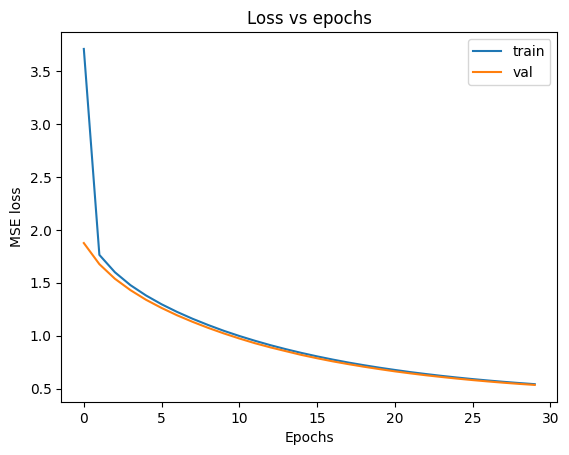

In [24]:
# Plot the losses

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

We can see that our linear regression model is underfitting.  WE CAN TELL THIS SINCE IT PERFORMS BETTER ON THE VALIDATION SET, IT CLEARLY HASNT LEARNED ENOUGH.

In [25]:
# Compute the train and validation loss of the linear regression Sequential model

print("Model train loss: {}".format(lr_model.evaluate(X_train, y_train, verbose=0)))
print("Model validation loss: {}".format(lr_model.evaluate(X_val, y_val, verbose=0)))

Model train loss: 0.5362328886985779
Model validation loss: 0.5342168211936951


Note that the model above is equivalent to fitting separate linear regression models for each scalar target output (`casual` and `registered`). However, these two models are clearly very closely related, and there is likely to be shared features that would be helpful for both models. 

In addition, we would like to train a higher capacity model to attempt to alleviate the underfitting we see in the linear regression model.

Both of these reasons are motivation for training a deeper multilayer perceptron (MLP) model. This is a higher capacity model that simple linear regression, and we expect that the intermediate features represented by the hidden layers will learn features of the data that are useful for predicting both of the target variables.

You should now complete the following `get_mlp` function to build an MLP model according to the following spec:

* The function takes the arguments `input_shape` and `hidden_layers`
* `hidden_layers` is a list of integers, corresponding to the number of neurons in the hidden layers
* The function should build the MLP using the `Sequential` API
  * It should use the `input_shape` argument in the first layer of the model
  * The hidden layers should each use a ReLU activation function
  * The output layer should have 2 neurons, and not use an activation function
* The function should then return the model object

In [26]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_mlp(input_shape, hidden_layers):
    """
    This function takes the input_shape, hidden_layers and output_units as arguments 
    to build a Sequential model as specified above. 
    The function should then return the Sequential model.
    """
    model = Sequential()
    for i, units in enumerate(hidden_layers):
        #for the first layer we tell it the shape so it can be made without the initial compliation
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=input_shape))
        else:
            model.add(Dense(units, activation='relu'))
    if len(hidden_layers) > 0:
        model.add(Dense(2))
    else:
        model.add(Dense(2, input_shape=input_shape))
    return model
    

In [27]:
# Run your function to build the model and print the model summary

mlp_model = get_mlp(input_shape=X_train.shape[1:], hidden_layers=[64, 32])
mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 6306 (24.63 KB)
Trainable params: 6306 (24.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Run your compile_and_fit function on the MLP

history = compile_and_fit(mlp_model, num_epochs=30, training_data=(X_train, y_train), 
                          val_data=(X_val, y_val), batch_size=128)

Epoch 1/30
96/96 [==============================] - 1s 2ms/step - loss: 2.6735 - val_loss: 1.4785
Epoch 2/30
96/96 [==============================] - 0s 1ms/step - loss: 1.2670 - val_loss: 1.0896
Epoch 3/30
96/96 [==============================] - 0s 1ms/step - loss: 0.9113 - val_loss: 0.7970
Epoch 4/30
96/96 [==============================] - 0s 1ms/step - loss: 0.6533 - val_loss: 0.5776
Epoch 5/30
96/96 [==============================] - 0s 1ms/step - loss: 0.5179 - val_loss: 0.5708
Epoch 6/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4648 - val_loss: 0.4574
Epoch 7/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4375 - val_loss: 0.5574
Epoch 8/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4223 - val_loss: 0.4221
Epoch 9/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4070 - val_loss: 0.4117
Epoch 10/30
96/96 [==============================] - 0s 1ms/step - loss: 0.3947 - val_loss: 0.4038
Epoch 11/30
96/96 [

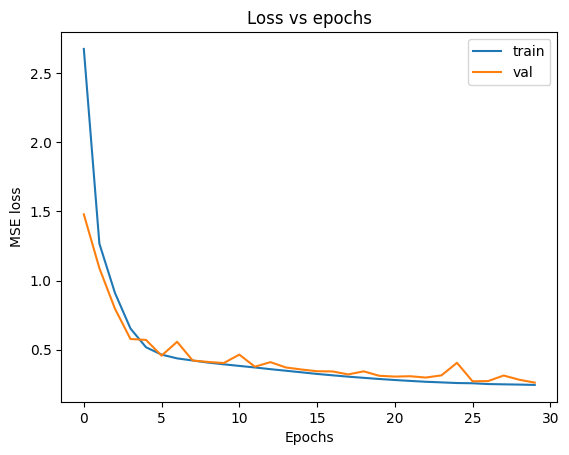

In [29]:
# Plot the losses

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

In [30]:
# Compute the train and validation loss of the linear regression Sequential model

print("Model train loss: {}".format(mlp_model.evaluate(X_train, y_train, verbose=0)))
print("Model validation loss: {}".format(mlp_model.evaluate(X_val, y_val, verbose=0)))

#THIS IS MUCH LOWER, and validtion is worse than training, which is sort of what we expect.

Model train loss: 0.24335744976997375
Model validation loss: 0.26246485114097595


The model performance has improved significantly using the MLP instead of linear regression. However, there is still room for improvement - the model is still underfitting and so we should try further increasing the capacity. You should try re-building and training MLP models for different hyperparameter settings to see how much you are able to improve the performance.

Congratulations on completing this week's assignment! You have now implemented linear regression using the Keras API, as well as an MLP model, and compared the performance.